In [1]:

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from qiskit import Aer
from qiskit.aqua.algorithms import AmplitudeEstimation
from qiskit.aqua.components.uncertainty_models import LogNormalDistribution
from qiskit.aqua.components.uncertainty_problems import UnivariateProblem
from qiskit.aqua.components.uncertainty_problems import UnivariatePiecewiseLinearObjective as PwlObjective

In [19]:

# number of qubits to represent the uncertainty
num_uncertainty_qubits = 4

# parameters for considered random distribution
S = 2.0 # initial spot price
vol = 0.4 # volatility of 40%
r = 0.05 # annual interest rate of 4%
T = 40 / 365 # 40 days to maturity

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low  = np.maximum(0, mean - 3*stddev)
high = mean + 3*stddev

# construct circuit factory for uncertainty model
uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma, low=low, high=high)

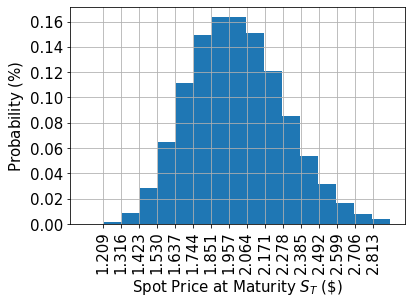

In [20]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.show()

In [40]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price_1 = 1.423
strike_price_2 = 2.385

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [uncertainty_model.low, strike_price_1, strike_price_2]
slopes = [0, 1, 0]
offsets = [0, 0, strike_price_2 - strike_price_1]
f_min = 0
f_max = strike_price_2 - strike_price_1
bull_spread_objective = PwlObjective(
    uncertainty_model.num_target_qubits, 
    uncertainty_model.low, 
    uncertainty_model.high,
    breakpoints,
    slopes,
    offsets,
    f_min,
    f_max,
    c_approx
)

# construct circuit factory for payoff function
bull_spread = UnivariateProblem(
    uncertainty_model,
    bull_spread_objective
)

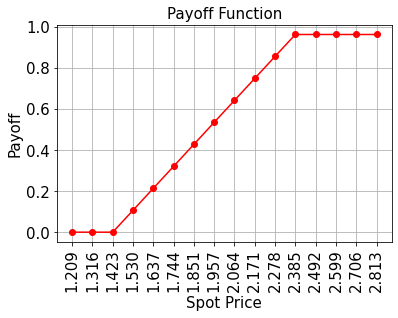

In [39]:

# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.minimum(np.maximum(0, x - strike_price_1), strike_price_2 - strike_price_1)
plt.plot(x, y, 'ro-')
plt.grid()
plt.title('Payoff Function', size=15)
plt.xlabel('Spot Price', size=15)
plt.ylabel('Payoff', size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [23]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[np.logical_and(x >= strike_price_1, x <= strike_price_2)])
print('exact expected value:\t%.4f' % exact_value)
print('exact delta value:   \t%.4f' % exact_delta)

exact expected value:	0.5740
exact delta value:   	0.8750


In [24]:
# set number of evaluation qubits (=log(samples))
m = 6

# construct amplitude estimation 
ae = AmplitudeEstimation(m, bull_spread)

In [25]:
# result = ae.run(quantum_instance=BasicAer.get_backend('qasm_simulator'), shots=100)
result = ae.run(quantum_instance=Aer.get_backend('statevector_simulator'))

In [26]:
print('Exact value:    \t%.4f' % exact_value)
print('Estimated value:\t%.4f' % result['estimation'])
print('Probability:    \t%.4f' % result['max_probability'])

Exact value:    	0.5740
Estimated value:	0.6011
Probability:    	0.8245


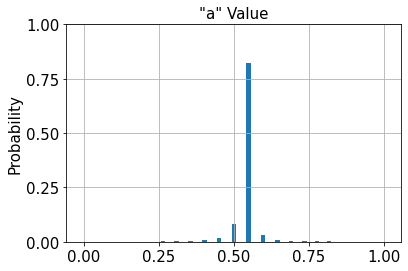

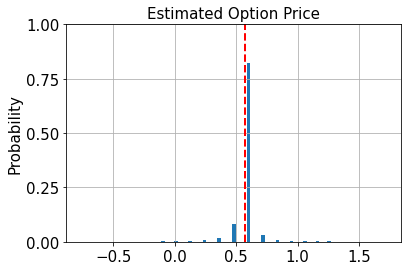

In [27]:
plt.bar(result['values'], result['probabilities'], width=0.5/len(result['probabilities']))
plt.xticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('"a" Value', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

# plot estimated values for option price (after re-scaling and reversing the c_approx-transformation)
plt.bar(result['mapped_values'], result['probabilities'], width=1/len(result['probabilities']))
plt.plot([exact_value, exact_value], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Option Price', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

In [28]:
breakpoints = [uncertainty_model.low, strike_price_1, strike_price_2]
slopes = [0, 0, 0]
offsets = [0, 1, 0]
f_min = 0
f_max = 1
c_approx = 1  # no approximation necessary
bull_spread_delta_objective = PwlObjective(
    uncertainty_model.num_target_qubits, 
    uncertainty_model.low, 
    uncertainty_model.high,
    breakpoints,
    slopes,
    offsets,
    f_min,
    f_max,
    c_approx
)

# construct circuit factory for payoff function
bull_spread_delta = UnivariateProblem(
    uncertainty_model,
    bull_spread_delta_objective
)

In [29]:

# set number of evaluation qubits (=log(samples))
m = 6

# construct amplitude estimation 
ae_delta = AmplitudeEstimation(m, bull_spread_delta)

In [30]:
# result_delta = ae_delta.run(quantum_instance=BasicAer.get_backend('qasm_simulator'), shots=100)
result_delta = ae_delta.run(quantum_instance=Aer.get_backend('statevector_simulator'))

In [31]:
print('Exact delta:   \t%.4f' % exact_delta)
print('Esimated value:\t%.4f' % result_delta['estimation'])
print('Probability:   \t%.4f' % result_delta['max_probability'])

Exact delta:   	0.8750
Esimated value:	0.8865
Probability:   	0.6355


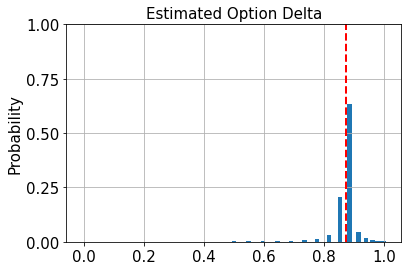

In [32]:
# plot estimated values for delta
plt.bar(result_delta['values'], result_delta['probabilities'], width=0.5/len(result_delta['probabilities']))
plt.plot([exact_delta, exact_delta], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Option Delta', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()